In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib import pyplot as plt

In [2]:
# We load the data and delete the columns that we won't use.
film_data = pd.read_csv('imdb_films.csv', index_col='id')
film_data = film_data.drop(['url','PosterLink','Description','duration','ReviewAurthor', 'ReviewDate'], axis=1)

In [3]:
film_data.columns

Index(['Name', 'Genres', 'Actors', 'Director', 'DatePublished', 'Keywords',
       'RatingCount', 'BestRating', 'WorstRating', 'RatingValue',
       'ReviewBody'],
      dtype='object')

In [4]:
# This column is almost not informative, so we can delete it.
film_data['BestRating'].value_counts()

BestRating
 10.0    48476
-1.0        36
 11.0        1
Name: count, dtype: int64

In [5]:
# This column is almost not informative, so we can delete it.
film_data['WorstRating'].value_counts()

WorstRating
 1.0    48477
-1.0       36
Name: count, dtype: int64

In [6]:
film_data = film_data.drop(['BestRating', 'WorstRating'], axis=1)
# RatingValue < 0 — movies that have not been released yet, we will remove them from the selection.
film_data = film_data[film_data['RatingValue'] > 0]

In [7]:
genres_explode = film_data.copy()
genres_explode['Genres'] = genres_explode['Genres'].str.split(',')
genres_explode = genres_explode.explode('Genres')


<Axes: xlabel='RatingValue', ylabel='Count'>

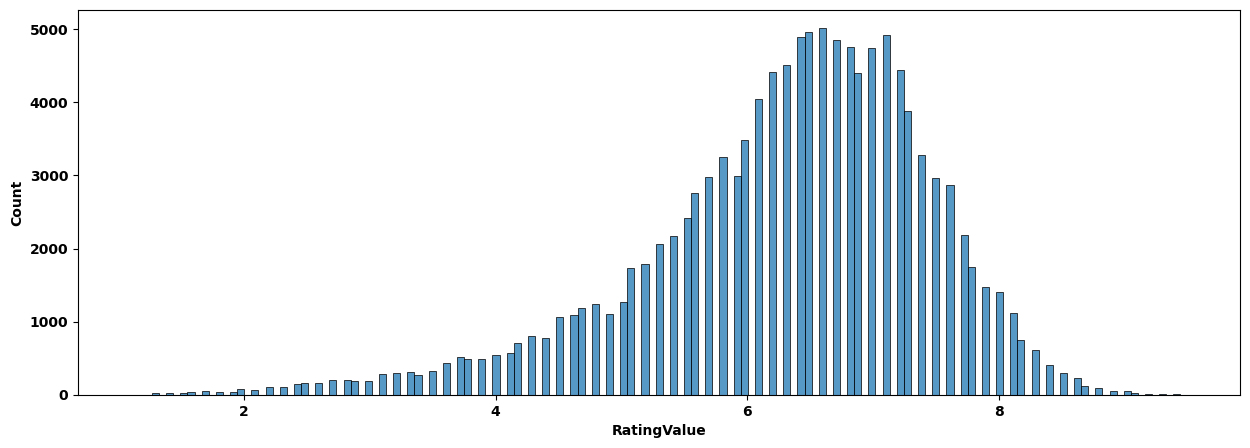

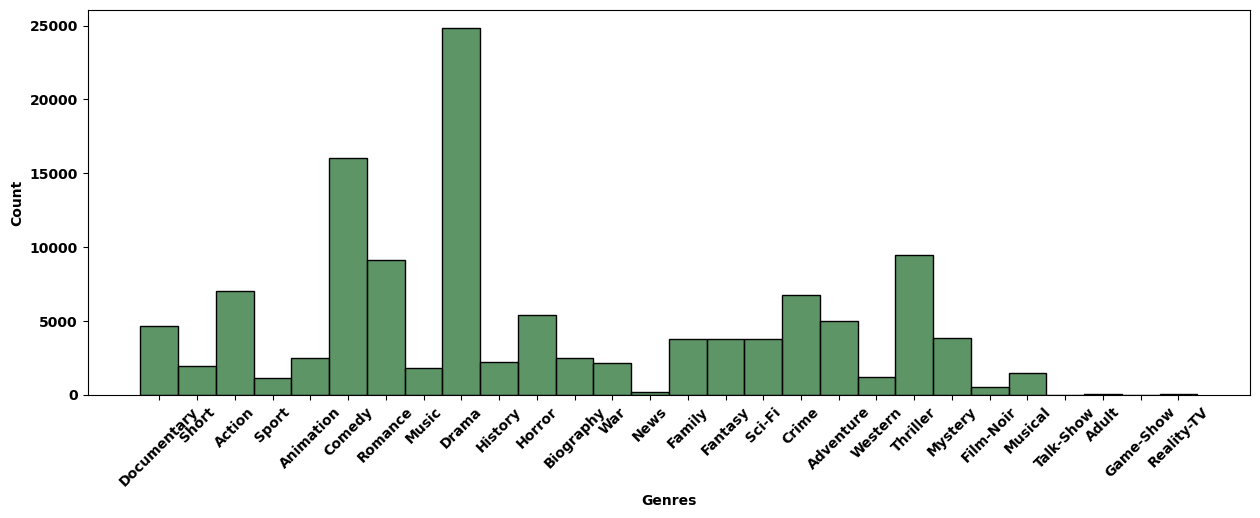

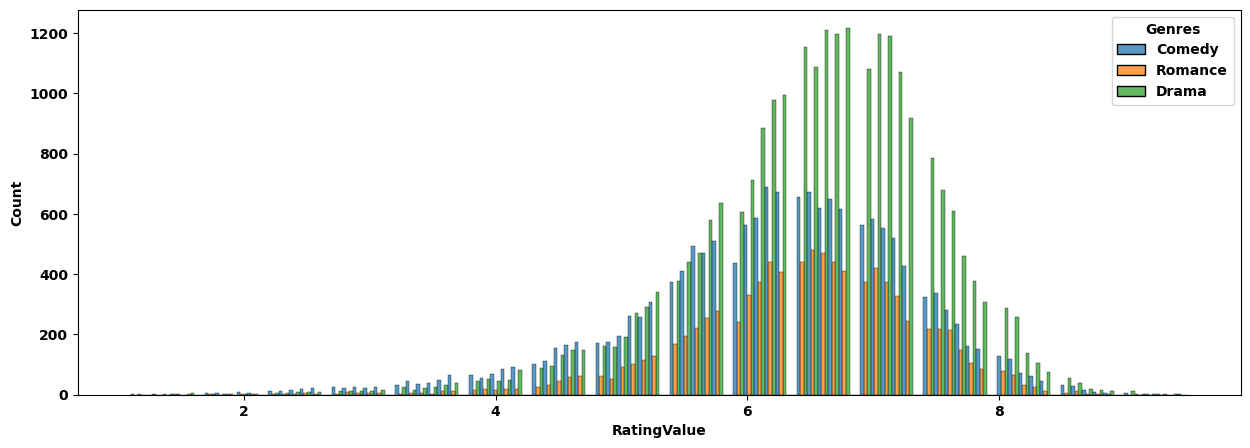

In [8]:
plt.figure(figsize=(15,5))
sns.histplot(data=genres_explode, x='RatingValue')

plt.figure(figsize=(15,5))
sns.histplot(genres_explode['Genres'], color='#287233')
plt.xticks(rotation=45);

# Гистограмма рейтинга по 3 самым популярным жанрам ['Romance', 'Comedy', 'Drama']
plt.figure(figsize=(15,5))
sns.histplot(data=genres_explode[genres_explode['Genres'].isin(['Romance', 'Comedy', 'Drama'])], \
             x='RatingValue', hue='Genres', multiple='dodge', bins=100)


In [9]:
# Let's add a feature whose value is the length of the review for this movie.
film_data['Len_review'] = film_data[film_data['ReviewBody'].isna() != True].apply(lambda x: len(x['ReviewBody']), axis=1)

In [10]:
film_data = film_data.dropna(subset='ReviewBody')

In [11]:
# Turning the text in the "Genres" column into an array of genres
film_data['Genres'] = film_data['Genres'].str.split(',')

# Turning the text in the "Actors" column into an array of actors
film_data['Actors'] = film_data['Actors'].str.split(',')

# Turning the text in the "Keywords" column into an array of keywords
film_data['Keywords'] = film_data['Keywords'].str.split(',')

The number of films in which the actor starred:

In [13]:
actors_frequence = film_data['Actors'].explode().value_counts()
actors_frequence

Actors
Clarence Nash       123
John Wayne          108
Gérard Depardieu     94
Michael Caine        91
Robert De Niro       91
                   ... 
Mohsen Ramezani       1
Salameh Feyzi         1
Farahnaz Safari       1
Gareth Milne          1
Naomi Grossman        1
Name: count, Length: 71656, dtype: int64

In [14]:
def count_freq(list_freq, freq_dict):
    summ = 0
    if list_freq is np.nan:
        return None
    for key in list_freq:
        summ += freq_dict[key]
    return summ

Creating a feature, the value of which is the sum of the number of films in which the actors who played in this film starred.
 For example, if actors John, Chris, Andrew and 
 actor John played in 20 films, Chris in 7, and Andrew in 1,
then the value of the feature = 20+7+1 = 28

In [16]:
film_data['Actors_sum_freq'] = film_data['Actors'].apply(count_freq, args=(actors_frequence,))

film_data['Actors_sum_freq'] = film_data['Actors_sum_freq'].fillna(film_data['Actors_sum_freq'].median())

In [17]:
keywords_frequence = film_data['Keywords'].explode().value_counts()
keywords_frequence

Keywords
psychotronic film             1366
f rated                       1171
murder                        1065
female nudity                  995
character name as title        857
                              ... 
african american superhero       1
1990s tv                         1
uso bombing                      1
ant analogy                      1
flying shark                     1
Name: count, Length: 37076, dtype: int64

Creating a feature whose value is the sum of the frequency of keywords

In [19]:
film_data['Keywords_sum_freq'] = film_data['Keywords'].apply(count_freq, args=(keywords_frequence,))
film_data['Keywords_sum_freq'] = film_data['Keywords_sum_freq'].fillna(film_data['Keywords_sum_freq'].interpolate())

<Axes: xlabel='DatePublished', ylabel='Count'>

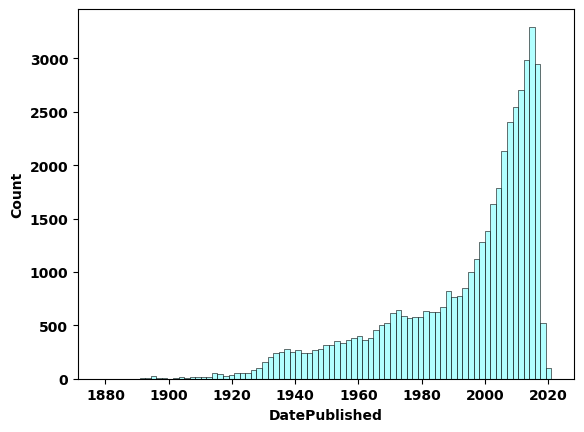

In [20]:
sns.histplot(pd.to_datetime(film_data['DatePublished']), color='#99FFFF')

In [21]:
film_data['Date_published_num'] = pd.to_datetime(film_data['DatePublished'])
film_data['Date_published_num'] = pd.to_numeric(film_data['Date_published_num'] \
                            .fillna(film_data['Date_published_num'].interpolate())) / 10**(15)

In [22]:
film_data = film_data.dropna(subset=['Genres', 'Director'])
film_data.isna().sum()

Name                     0
Genres                   0
Actors                 550
Director                 0
DatePublished          612
Keywords              1509
RatingCount              0
RatingValue              0
ReviewBody               0
Len_review               0
Actors_sum_freq          0
Keywords_sum_freq        0
Date_published_num       0
dtype: int64

In [23]:
film_data['Director'] = film_data['Director'].str.split(',')

Creating a feature that takes into account the number of films directed by the director.

In [25]:
directors = film_data['Director'].explode().value_counts()
film_data['Count_films'] = film_data['Director'].apply(count_freq, args=(directors,))

In [26]:
# One-Hot Encoding
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(film_data['Genres'])
encoded_df = pd.DataFrame(encoded_labels, columns=mlb.classes_)
encoded_df.index = film_data.index

film_data = pd.concat([film_data, encoded_df], axis=1)

In [27]:
processed_data = film_data.drop(['Name', 'Genres', 'Actors', 'Director', 'DatePublished', 'Keywords', 'ReviewBody'], axis=1)

In [28]:
processed_data.to_csv('processed_films_data.csv')